In [4]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from tensorflow import keras
from keras.models import Sequential
from keras import Input
from keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.callbacks import EarlyStopping

from lightgbm import LGBMRegressor
import random
import xgboost as xgb

In [2]:
curr_dir = os.getcwd()
curr_dir

'C:\\weather\\uv'

In [3]:
forders_tr = os.listdir(curr_dir+"\\data\\"+"\\train_val")
forders_tr

['202001_uv.csv',
 '202002_uv.csv',
 '202003_uv.csv',
 '202004_uv.csv',
 '202005_uv.csv',
 '202006_uv.csv',
 '202007_uv.csv',
 '202008_uv.csv',
 '202009_uv.csv',
 '202010_uv.csv',
 '202011_uv.csv',
 '202012_uv.csv',
 '202101_uv.csv',
 '202102_uv.csv',
 '202103_uv.csv',
 '202104_uv.csv',
 '202105_uv.csv',
 '202106_uv.csv',
 '202107_uv.csv',
 '202108_uv.csv',
 '202109_uv.csv',
 '202110_uv.csv',
 '202111_uv.csv',
 '202112_uv.csv']

In [4]:
forders_tr1 = []
for i in range(0,9):
    df = pd.read_csv(os.path.join(curr_dir+"\\data\\"+"\\train_val\\")+forders_tr[i])
    d = list(df.columns)
    for j in range(1,len(d)):
        d[j] = d[j].replace("20200"+str(i+1)+"_uv.", "")
    df.columns = d
    df.drop('Unnamed: 0', axis=1, inplace=True)
    forders_tr1.append(df)

for i in range(9,12):
    df = pd.read_csv(os.path.join(curr_dir+"\\data\\"+"\\train_val\\")+forders_tr[i])
    d = list(df.columns)
    for j in range(1,len(d)):
        d[j] = d[j].replace("2020"+str(i+1)+"_uv.", "")
    df.columns = d
    df.drop('Unnamed: 0', axis=1, inplace=True)
    forders_tr1.append(df)

    
for i in range(12,21):
    df = pd.read_csv(os.path.join(curr_dir+"\\data\\"+"\\train_val\\")+forders_tr[i])
    d = list(df.columns)
    for j in range(1,len(d)):
        d[j] = d[j].replace("20210"+str(i+1-12)+"_uv.", "")
    df.columns = d
    df.drop('Unnamed: 0', axis=1, inplace=True)
    forders_tr1.append(df)

for i in range(21,24):
    df = pd.read_csv(os.path.join(curr_dir+"\\data\\"+"\\train_val\\")+forders_tr[i])
    d = list(df.columns)
    for j in range(1,len(d)):
        d[j] = d[j].replace("2021"+str(i+1-12)+"_uv.", "")
    df.columns = d
    df.drop('Unnamed: 0', axis=1, inplace=True)
    forders_tr1.append(df)

In [5]:
# 새로운 데이터 프레임 생성
train = pd.DataFrame()

for files in forders_tr1[:-5]:
    train = pd.concat([train, files])
train

,yyyymmdd,hhnn,stn,lon,lat,uv,band1,band2,band3,band4,...,band12,band13,band14,band15,band16,solarza,sateza,esr,height,landtype
0,20200101,0,13,126.16000,33.30000,0.0,0.00000,0.00000,0.00000,-0.00075,...,250.75924,269.97608,269.70811,268.61702,259.10334,165.17963,38.96359,-9.50910,71.00,0
1,20200101,0,105,128.89098,37.75147,0.0,-0.00057,0.00057,0.00030,-0.00030,...,246.67115,268.22810,268.41686,268.01723,256.99670,163.20549,43.95463,-9.40930,26.04,3
2,20200101,0,108,126.96500,37.57100,-999.0,0.00000,0.00000,-0.00089,-0.00075,...,241.24994,258.33982,258.18692,257.58363,250.50021,162.48279,43.77999,-9.37761,85.50,3
3,20200101,0,112,126.62490,37.47772,0.0,-0.00057,-0.00057,-0.00060,0.00015,...,241.55488,258.54927,258.64012,258.03883,251.00820,162.39995,43.67046,-9.37422,68.99,3
4,20200101,0,115,130.89864,37.48129,0.0,0.00000,-0.00057,-0.00030,0.00075,...,244.56708,264.88004,263.95472,262.33534,253.25397,164.19725,43.74521,-9.45200,222.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66955,20210731,2350,146,127.11900,35.84080,0.1,0.00000,-0.00057,0.00030,-0.00060,...,264.53165,291.90287,290.09587,285.48855,270.82702,124.36364,41.81018,-4.72602,62.90,3
66956,20210731,2350,152,129.33472,35.58250,0.0,0.00000,0.00000,0.00000,-0.00030,...,262.88449,288.27382,286.67481,282.45891,269.23268,125.09137,41.52495,-4.87156,82.00,2
66957,20210731,2350,156,126.89158,35.17294,0.0,-0.00057,0.00000,0.00000,0.00015,...,262.57588,287.50208,284.96722,280.05240,267.56515,124.95628,41.04849,-4.79509,72.38,3
66958,20210731,2350,159,129.03203,35.10468,0.0,0.00000,0.00000,-0.00119,0.00000,...,262.22936,287.43410,286.66069,283.63739,270.60537,125.49764,40.96396,-4.91507,69.56,3


In [29]:
train['uv'].value_counts()             # -999많음.

 0.0      623140
 0.1       54484
-999.0     49316
 0.2       32427
 0.3       25304
           ...  
 12.5          3
 13.3          1
 13.7          1
 14.4          1
 18.9          1
Name: uv, Length: 138, dtype: int64

In [59]:
# ind_tr = []
# for i in range(len(train.columns)):
#     ind_tr = ind_tr + list(train[train[train.columns[i]] == -999.0].index)
# ind_tr

[2,
 9,
 10,
 17,
 25,
 32,
 39,
 40,
 47,
 54,
 55,
 62,
 70,
 77,
 85,
 92,
 99,
 100,
 107,
 114,
 115,
 122,
 129,
 130,
 137,
 145,
 152,
 160,
 167,
 175,
 182,
 190,
 197,
 204,
 205,
 212,
 220,
 227,
 235,
 242,
 249,
 250,
 257,
 264,
 265,
 272,
 280,
 287,
 294,
 295,
 302,
 317,
 324,
 325,
 332,
 340,
 347,
 354,
 355,
 362,
 369,
 370,
 377,
 384,
 392,
 399,
 407,
 422,
 429,
 437,
 452,
 467,
 482,
 489,
 497,
 504,
 512,
 527,
 542,
 557,
 572,
 579,
 587,
 602,
 617,
 624,
 632,
 639,
 647,
 662,
 677,
 692,
 707,
 722,
 737,
 752,
 767,
 782,
 797,
 812,
 827,
 842,
 857,
 872,
 887,
 902,
 917,
 932,
 947,
 962,
 977,
 992,
 1007,
 1022,
 1037,
 1052,
 1067,
 1082,
 1097,
 1112,
 1127,
 1142,
 1157,
 1172,
 1187,
 1202,
 1217,
 1232,
 1247,
 1262,
 1277,
 1292,
 1307,
 1322,
 1337,
 1352,
 1367,
 1382,
 1397,
 1412,
 1427,
 1442,
 1457,
 1472,
 1487,
 1502,
 1517,
 1532,
 1547,
 1562,
 1577,
 1592,
 1607,
 1622,
 1629,
 1637,
 1644,
 1652,
 1667,
 1682,
 1697,
 171

In [60]:
len(ind_tr)

261957

In [14]:
train1 = train[train['uv'] != -999.0]
train1

,yyyymmdd,hhnn,stn,lon,lat,uv,band1,band2,band3,band4,...,band12,band13,band14,band15,band16,solarza,sateza,esr,height,landtype
0,20200101,0,13,126.16000,33.30000,0.0,0.00000,0.00000,0.00000,-0.00075,...,250.75924,269.97608,269.70811,268.61702,259.10334,165.17963,38.96359,-9.50910,71.00,0
1,20200101,0,105,128.89098,37.75147,0.0,-0.00057,0.00057,0.00030,-0.00030,...,246.67115,268.22810,268.41686,268.01723,256.99670,163.20549,43.95463,-9.40930,26.04,3
3,20200101,0,112,126.62490,37.47772,0.0,-0.00057,-0.00057,-0.00060,0.00015,...,241.55488,258.54927,258.64012,258.03883,251.00820,162.39995,43.67046,-9.37422,68.99,3
4,20200101,0,115,130.89864,37.48129,0.0,0.00000,-0.00057,-0.00030,0.00075,...,244.56708,264.88004,263.95472,262.33534,253.25397,164.19725,43.74521,-9.45200,222.80,4
5,20200101,0,131,127.44066,36.63924,0.0,0.00000,0.00000,0.00000,-0.00015,...,245.02255,263.96330,264.23788,263.88311,254.98555,163.46199,42.69599,-9.42573,58.70,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66955,20210731,2350,146,127.11900,35.84080,0.1,0.00000,-0.00057,0.00030,-0.00060,...,264.53165,291.90287,290.09587,285.48855,270.82702,124.36364,41.81018,-4.72602,62.90,3
66956,20210731,2350,152,129.33472,35.58250,0.0,0.00000,0.00000,0.00000,-0.00030,...,262.88449,288.27382,286.67481,282.45891,269.23268,125.09137,41.52495,-4.87156,82.00,2
66957,20210731,2350,156,126.89158,35.17294,0.0,-0.00057,0.00000,0.00000,0.00015,...,262.57588,287.50208,284.96722,280.05240,267.56515,124.95628,41.04849,-4.79509,72.38,3
66958,20210731,2350,159,129.03203,35.10468,0.0,0.00000,0.00000,-0.00119,0.00000,...,262.22936,287.43410,286.66069,283.63739,270.60537,125.49764,40.96396,-4.91507,69.56,3


In [16]:
val = pd.DataFrame()

for files in forders_tr1[-5:]:
    val = pd.concat([val, files])
val

,yyyymmdd,hhnn,stn,lon,lat,uv,band1,band2,band3,band4,...,band12,band13,band14,band15,band16,solarza,sateza,esr,height,landtype
0,20210801,0,13,126.16000,33.30000,0.0,0.00000,-0.00057,0.00089,-0.00015,...,264.44311,290.55389,288.92546,284.67080,270.70772,127.16116,38.96359,-5.60122,71.00,0
1,20210801,0,105,128.89098,37.75147,0.0,-0.00057,-0.00057,0.00000,-0.00015,...,259.14507,283.10942,282.76528,280.43877,268.61000,123.36327,43.95463,-5.09260,26.04,3
2,20210801,0,108,126.96500,37.57100,0.0,0.00000,0.00057,-0.00119,0.00120,...,252.93837,273.65182,270.18990,267.15459,258.99048,123.18739,43.77999,-5.07447,85.50,3
3,20210801,0,112,126.62490,37.47772,0.0,0.00000,0.00000,-0.00030,-0.00060,...,250.27920,268.14394,268.04466,266.56403,259.34748,123.22507,43.67046,-5.08058,68.99,3
4,20210801,0,115,130.89864,37.48129,0.0,0.00000,0.00000,0.00000,-0.00015,...,263.38986,289.67998,288.05013,284.04277,269.26719,123.91259,43.74521,-5.16058,222.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66955,20211231,2350,146,127.11900,35.84080,0.1,-0.00057,0.00000,-0.00060,0.00000,...,244.71129,264.82744,264.95943,264.36433,254.82929,162.52921,41.81018,-8.87355,62.90,3
66956,20211231,2350,152,129.33472,35.58250,0.0,0.00000,0.00000,-0.00179,-0.00015,...,241.75728,259.19303,257.86443,257.39333,249.08495,163.96606,41.52495,-8.99640,82.00,2
66957,20211231,2350,156,126.89158,35.17294,0.0,0.00000,0.00000,0.00000,0.00105,...,242.90744,260.33453,260.00405,259.18646,250.92709,162.84572,41.04849,-8.87987,72.38,3
66958,20211231,2350,159,129.03203,35.10468,0.0,-0.00057,-0.00057,0.00089,-0.00015,...,242.68420,259.36253,258.24370,256.93511,247.71243,164.15158,40.96396,-8.99480,69.56,3


In [17]:
val['uv'].value_counts()             # -999많음.

0.0     171262
0.1      25675
0.2       8945
0.3       6935
0.4       6667
         ...  
18.5         1
11.8         1
23.6         1
13.3         1
12.4         1
Name: uv, Length: 131, dtype: int64

In [18]:
val1 = val[val['uv'] != -999.0]
val1

,yyyymmdd,hhnn,stn,lon,lat,uv,band1,band2,band3,band4,...,band12,band13,band14,band15,band16,solarza,sateza,esr,height,landtype
0,20210801,0,13,126.16000,33.30000,0.0,0.00000,-0.00057,0.00089,-0.00015,...,264.44311,290.55389,288.92546,284.67080,270.70772,127.16116,38.96359,-5.60122,71.00,0
1,20210801,0,105,128.89098,37.75147,0.0,-0.00057,-0.00057,0.00000,-0.00015,...,259.14507,283.10942,282.76528,280.43877,268.61000,123.36327,43.95463,-5.09260,26.04,3
2,20210801,0,108,126.96500,37.57100,0.0,0.00000,0.00057,-0.00119,0.00120,...,252.93837,273.65182,270.18990,267.15459,258.99048,123.18739,43.77999,-5.07447,85.50,3
3,20210801,0,112,126.62490,37.47772,0.0,0.00000,0.00000,-0.00030,-0.00060,...,250.27920,268.14394,268.04466,266.56403,259.34748,123.22507,43.67046,-5.08058,68.99,3
4,20210801,0,115,130.89864,37.48129,0.0,0.00000,0.00000,0.00000,-0.00015,...,263.38986,289.67998,288.05013,284.04277,269.26719,123.91259,43.74521,-5.16058,222.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66955,20211231,2350,146,127.11900,35.84080,0.1,-0.00057,0.00000,-0.00060,0.00000,...,244.71129,264.82744,264.95943,264.36433,254.82929,162.52921,41.81018,-8.87355,62.90,3
66956,20211231,2350,152,129.33472,35.58250,0.0,0.00000,0.00000,-0.00179,-0.00015,...,241.75728,259.19303,257.86443,257.39333,249.08495,163.96606,41.52495,-8.99640,82.00,2
66957,20211231,2350,156,126.89158,35.17294,0.0,0.00000,0.00000,0.00000,0.00105,...,242.90744,260.33453,260.00405,259.18646,250.92709,162.84572,41.04849,-8.87987,72.38,3
66958,20211231,2350,159,129.03203,35.10468,0.0,-0.00057,-0.00057,0.00089,-0.00015,...,242.68420,259.36253,258.24370,256.93511,247.71243,164.15158,40.96396,-8.99480,69.56,3


In [23]:
forders_te = os.listdir(curr_dir+"\\data\\"+"\\test")
forders_te

df = pd.read_csv(os.path.join(curr_dir+"\\data\\"+"\\test\\")+forders_te[0])
d = list(df.columns)
for j in range(1,len(d)):
    d[j] = d[j].replace("202206_uv.", "")
df.columns = d
df.drop('Unnamed: 0', axis=1, inplace=True)
test = df
test

,yyyymmdd,hhnn,stn,lon,lat,uv,band1,band2,band3,band4,...,band12,band13,band14,band15,band16,solarza,sateza,esr,height,landtype
0,20220601,0,13,126.16000,33.30000,NaN,0.00000,0.00000,-0.00060,0.00060,...,241.07130,251.49092,250.11913,248.78686,243.12601,-999,38.96359,-999,71.00,0
1,20220601,0,105,128.89098,37.75147,NaN,-0.00057,-0.00057,0.00000,-0.00030,...,244.35010,262.71227,261.14580,257.52658,246.95577,-999,43.95463,-999,26.04,3
2,20220601,0,108,126.96500,37.57100,NaN,0.00000,-0.00057,-0.00030,0.00045,...,249.24111,271.81756,270.25616,266.99858,254.94651,-999,43.77999,-999,85.50,3
3,20220601,0,112,126.62490,37.47772,NaN,0.00000,0.00000,0.00060,0.00045,...,249.94977,273.52547,272.33661,269.12853,256.15036,-999,43.67046,-999,68.99,3
4,20220601,0,115,130.89864,37.48129,NaN,0.00000,0.00000,0.00089,-0.00030,...,239.88321,253.29031,251.46606,249.01625,240.92761,-999,43.74521,-999,222.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51850,20220625,0,146,127.11900,35.84080,NaN,0.00000,-0.00057,-0.00089,0.00015,...,258.49191,286.87485,287.19605,285.48855,271.35400,-999,41.81018,-999,62.90,3
51851,20220625,0,152,129.33472,35.58250,NaN,-0.00057,0.00000,-0.00030,-0.00030,...,263.99872,293.32422,293.51096,291.15861,274.60342,-999,41.52495,-999,82.00,2
51852,20220625,0,156,126.89158,35.17294,NaN,0.00000,0.00000,0.00089,-0.00030,...,261.53112,290.14436,290.23278,288.05655,273.15633,-999,41.04849,-999,72.38,3
51853,20220625,0,159,129.03203,35.10468,NaN,0.00000,0.00057,0.00030,-0.00075,...,260.95627,287.80066,287.63090,285.01340,270.36623,-999,40.96396,-999,69.56,3


# corr

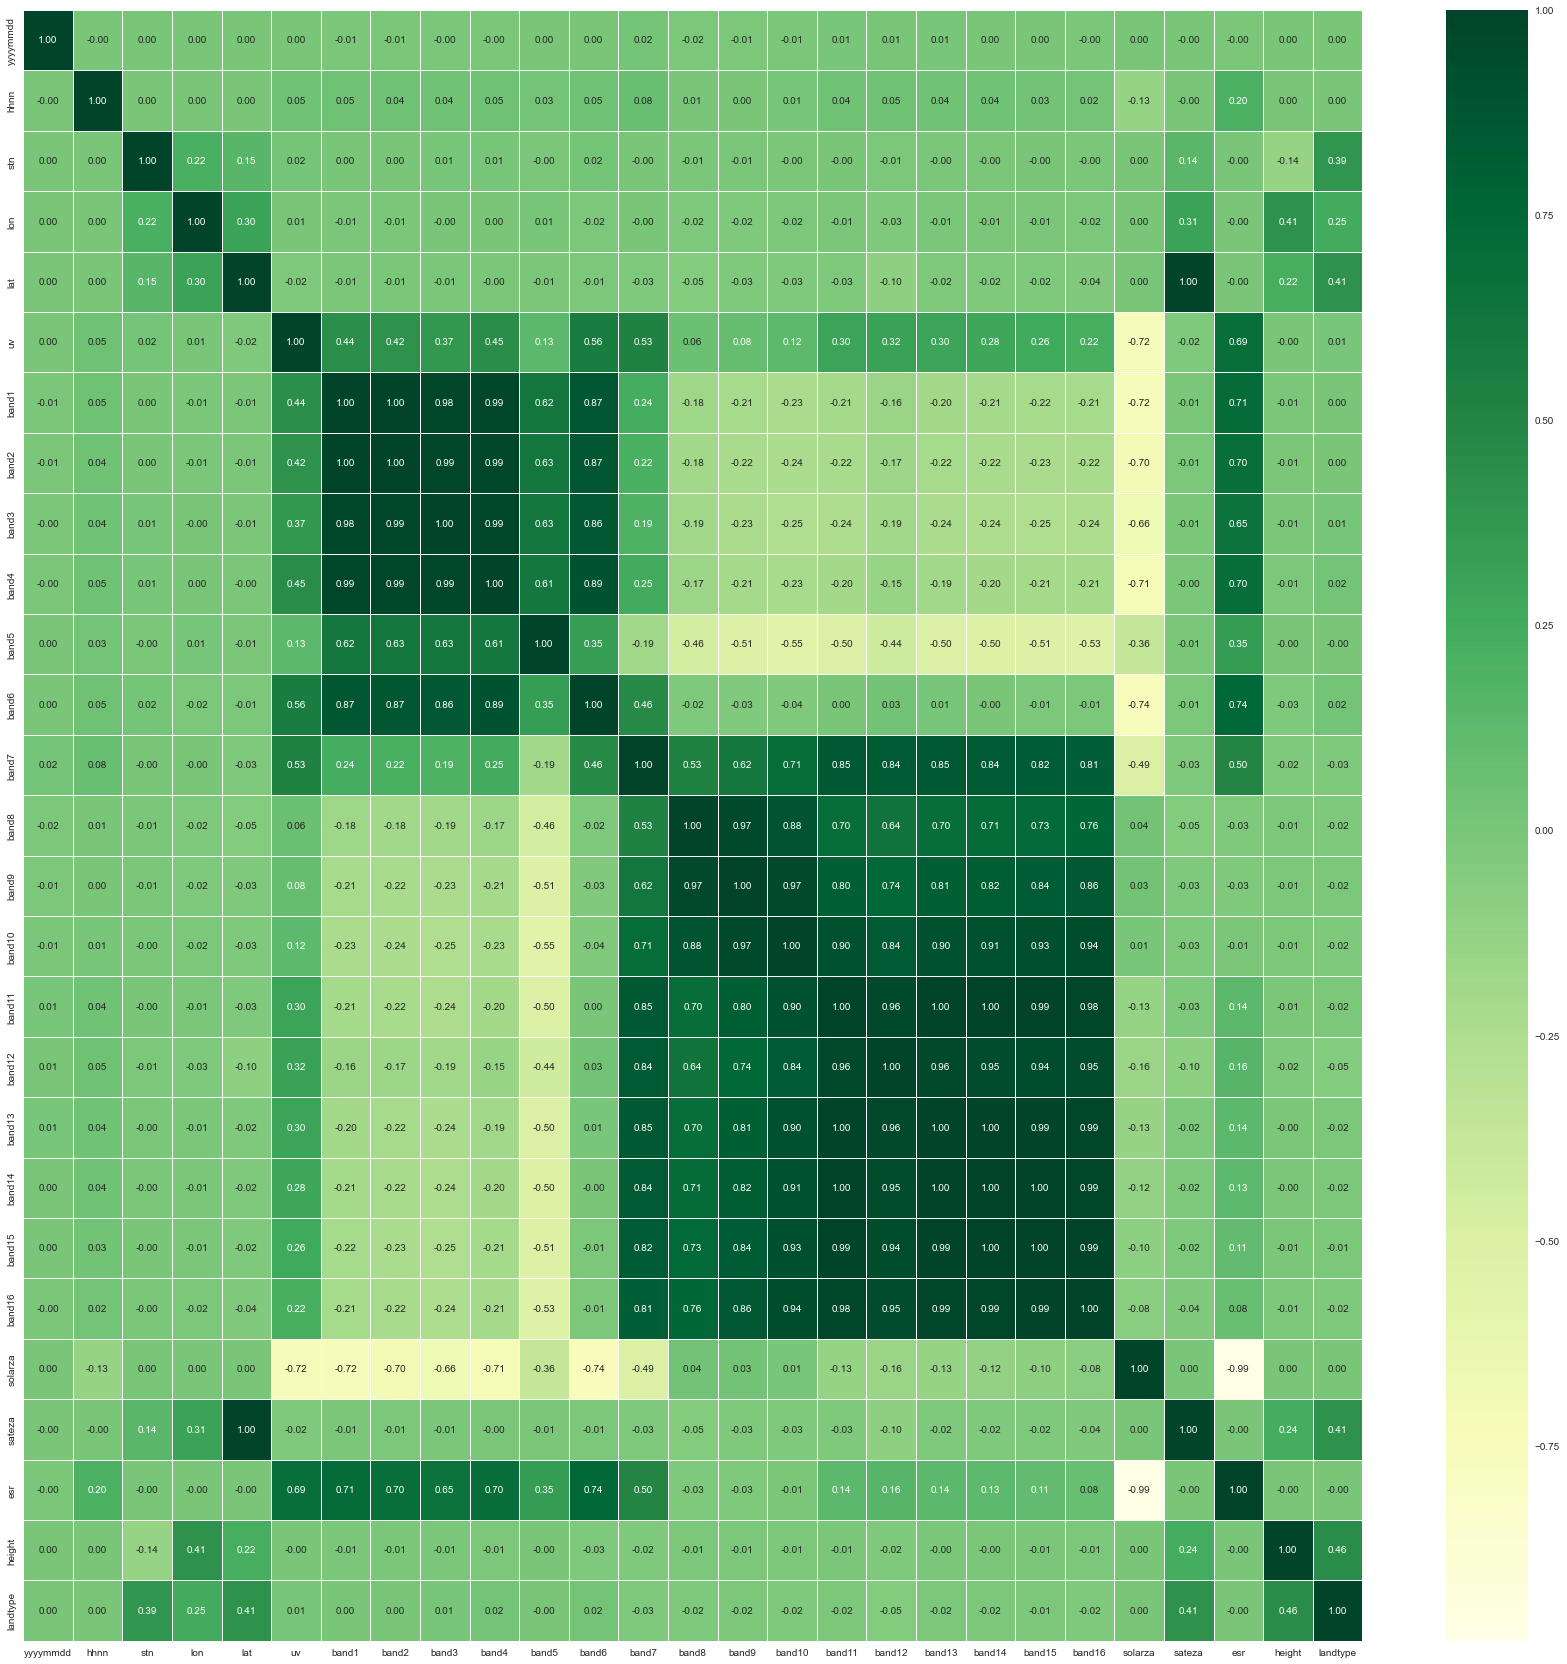

In [120]:
# outlier 제거
mask = train.isin([-999.0])
train1 = train[~mask]
# df2 = df1.drop([])
# train1.describe()

plt.figure(figsize=(30,30))
plt.style.use('seaborn')
sns.heatmap(data = train1.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='YlGn')
plt.savefig('corr_uv.png')

In [111]:
train.columns

Index(['Unnamed: 0', 'yyyymmdd', 'hhnn', 'stn', 'lon', 'lat', 'uv', 'band1',
       'band2', 'band3', 'band4', 'band5', 'band6', 'band7', 'band8', 'band9',
       'band10', 'band11', 'band12', 'band13', 'band14', 'band15', 'band16',
       'solarza', 'sateza', 'esr', 'height', 'landtype'],
      dtype='object')

In [8]:
max_depth = 5
n_estimators = 5000             # 400  #1000
lr = 0.01                     # 0.017
num_leaves = 31
early_stopping_rounds = 300      # 100
verbose = True                  # True

In [29]:
# def model_train(curr_dir):
 
#     path_train = os.path.join(curr_dir+"\\data_rota\\"+"\\train")
#     path_test = os.path.join(curr_dir+"\\data_rota\\"+"\\test")
    
#     folders_tr = os.listdir(path_train)
#     folders_test = os.listdir(path_test)
    
#     train = pd.DataFrame()
#     for files in folders_tr:
#         df= pd.read_csv(os.path.join(curr_dir+"\\data_rota\\"+"\\train\\")+files)
#         train = pd.concat([train, df])            
              
    
#     test = pd.DataFrame()
#     for files in folders_test:
#         df= pd.read_csv(os.path.join(curr_dir+"\\data_rota\\"+"\\test\\")+files)
#         test = pd.concat([test, df])   


#     X_train = train[['band1','band2', 'band3', 'band4','band6', 'band7','band11', 'band12', \
#                      'band13', 'band14', 'band15', 'band16','solarza','esr']]
#     X_val = val[['band1','band2', 'band3', 'band4','band6', 'band7','band11', 'band12', \
#                      'band13', 'band14', 'band15', 'band16','solarza','esr']]    
#     X_test = test[['band1','band2', 'band3', 'band4','band6', 'band7','band11', 'band12', \
#                      'band13', 'band14', 'band15', 'band16','solarza','esr']]
 
X_train = train1.drop('uv',axis=1)
X_val = val1.drop('uv',axis=1)
X_test = test.drop('uv',axis=1)
    
y_train = train1[['uv']].values
y_val = val1[['uv']].values



#     trainx = train[['band1','band2', 'band3', 'band4','band6', 'band7','band11', 'band12', \
#                      'band13', 'band14', 'band15', 'band16','solarza','esr']]
#     test1 = test[['band1','band2', 'band3', 'band4','band6', 'band7','band11', 'band12', \
#                      'band13', 'band14', 'band15', 'band16','solarza','esr']]
    
#     trainy = train[['uv']].values

#     X_train, X_val, y_train, y_val = train_test_split(trainx, trainy, test_size=0.3, shuffle=False)
    
#     param_grid = {
#     'n_estimators': [100, 150, 200, 250],
#     'max_depth': [None, 6, 9, 12],
#     'min_samples_split': [0.01, 0.05, 0.1],
#     'max_features': ['auto', 'sqrt']}
    
    
#     kf = KFold(random_state=30,
#            n_splits=3,
#            shuffle=True,
#           )
    
#     model_name = '\\save\\'+'best_model_v1.h5' 

#     filepath = os.path.join(os.getcwd()+ model_name)

#     es = EarlyStopping(monitor='val_mse', verbose=1, patience=20)

#     checkpoint = ModelCheckpoint(filepath=filepath,
#                              monitor='val_mse',
#                              verbose=1,
#                              save_best_only=True)

#     callbacks = [checkpoint, es]



xgb_model = xgb.XGBRegressor(n_estimators = 25000, learning_rate = 0.01, \
                              max_depth=5, subsample=0.5,colsample_bytree=0.7,  \
                    random_state = 2000)

xgb_model.fit(X_train,y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=15)



# lgbm_reg = LGBMRegressor(objective= "regression",
#                      max_depth= max_depth,
#                      n_estimators= n_estimators,
#                      learning_rate= lr,
#                      num_leaves = num_leaves)
    
# lgbm_reg.fit(X_train, y_train,
#           eval_set=[(X_val, y_val)],
#           eval_metric=["mse"],
#           early_stopping_rounds=early_stopping_rounds,
#           verbose=verbose) 



#     estimator = xgb.XGBRegressor()
    # define grid_search
#     grid_search = GridSearchCV(estimator=estimator, 
#                                param_grid=param_grid, 
#                                cv=kf, 
#                                n_jobs=-1, 
#                                verbose=2
#                               )

    # fit with (x_train, y_train)
#     grid_search.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=1)
    
#     feature_importance = xgb_model.feature_importances_
#     sorted_idx = np.argsort(feature_importance)
#     fig = plt.figure(figsize=(12, 6))
#     plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
#     plt.yticks(range(len(sorted_idx)), np.array(X_val.columns)[sorted_idx])
#     plt.title('Feature Importance')
    
#     pred = xgb_model.predict(test1)
#     submission=pd.read_csv('1-1_검증데이터셋.csv', encoding='utf-8')
#     submission1=submission.copy()
#     submission1['UV'] = pred
    
#     submission1.to_csv("220224_xgb_uv.csv", index = False)

C:\Users\wjd72\anaconda3\envs\tensorflow_env\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:1.72904
[1]	validation_0-rmse:1.71514
[2]	validation_0-rmse:1.70136
[3]	validation_0-rmse:1.68770
[4]	validation_0-rmse:1.67425
[5]	validation_0-rmse:1.66090
[6]	validation_0-rmse:1.64712
[7]	validation_0-rmse:1.63349
[8]	validation_0-rmse:1.62052
[9]	validation_0-rmse:1.60723
[10]	validation_0-rmse:1.59398
[11]	validation_0-rmse:1.58090
[12]	validation_0-rmse:1.56858
[13]	validation_0-rmse:1.55569
[14]	validation_0-rmse:1.54360
[15]	validation_0-rmse:1.53115
[16]	validation_0-rmse:1.51889
[17]	validation_0-rmse:1.50721
[18]	validation_0-rmse:1.49526
[19]	validation_0-rmse:1.48326
[20]	validation_0-rmse:1.47163
[21]	validation_0-rmse:1.45980
[22]	validation_0-rmse:1.44819
[23]	validation_0-rmse:1.43703
[24]	validation_0-rmse:1.42621
[25]	validation_0-rmse:1.41493
[26]	validation_0-rmse:1.40375
[27]	validation_0-rmse:1.39310
[28]	validation_0-rmse:1.38226
[29]	validation_0-rmse:1.37148
[30]	validation_0-rmse:1.36095
[31]	validation_0-rmse:1.35067
[32]	validation_0-

[260]	validation_0-rmse:0.49398
[261]	validation_0-rmse:0.49327
[262]	validation_0-rmse:0.49224
[263]	validation_0-rmse:0.49087
[264]	validation_0-rmse:0.48994
[265]	validation_0-rmse:0.48916
[266]	validation_0-rmse:0.48847
[267]	validation_0-rmse:0.48755
[268]	validation_0-rmse:0.48675
[269]	validation_0-rmse:0.48530
[270]	validation_0-rmse:0.48464
[271]	validation_0-rmse:0.48401
[272]	validation_0-rmse:0.48307
[273]	validation_0-rmse:0.48234
[274]	validation_0-rmse:0.48167
[275]	validation_0-rmse:0.48117
[276]	validation_0-rmse:0.48045
[277]	validation_0-rmse:0.47990
[278]	validation_0-rmse:0.47923
[279]	validation_0-rmse:0.47832
[280]	validation_0-rmse:0.47770
[281]	validation_0-rmse:0.47704
[282]	validation_0-rmse:0.47651
[283]	validation_0-rmse:0.47556
[284]	validation_0-rmse:0.47500
[285]	validation_0-rmse:0.47449
[286]	validation_0-rmse:0.47393
[287]	validation_0-rmse:0.47330
[288]	validation_0-rmse:0.47267
[289]	validation_0-rmse:0.47217
[290]	validation_0-rmse:0.47133
[291]	va

[517]	validation_0-rmse:0.41682
[518]	validation_0-rmse:0.41658
[519]	validation_0-rmse:0.41638
[520]	validation_0-rmse:0.41634
[521]	validation_0-rmse:0.41645
[522]	validation_0-rmse:0.41639
[523]	validation_0-rmse:0.41620
[524]	validation_0-rmse:0.41617
[525]	validation_0-rmse:0.41605
[526]	validation_0-rmse:0.41597
[527]	validation_0-rmse:0.41587
[528]	validation_0-rmse:0.41584
[529]	validation_0-rmse:0.41576
[530]	validation_0-rmse:0.41571
[531]	validation_0-rmse:0.41563
[532]	validation_0-rmse:0.41558
[533]	validation_0-rmse:0.41553
[534]	validation_0-rmse:0.41537
[535]	validation_0-rmse:0.41530
[536]	validation_0-rmse:0.41530
[537]	validation_0-rmse:0.41527
[538]	validation_0-rmse:0.41542
[539]	validation_0-rmse:0.41534
[540]	validation_0-rmse:0.41529
[541]	validation_0-rmse:0.41512
[542]	validation_0-rmse:0.41507
[543]	validation_0-rmse:0.41505
[544]	validation_0-rmse:0.41496
[545]	validation_0-rmse:0.41490
[546]	validation_0-rmse:0.41470
[547]	validation_0-rmse:0.41462
[548]	va

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=25000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=2000,
             reg_alpha=0, reg_lambda=1, ...)

In [ ]:
# 결측치를 제거하고하니 바로 1점대부터 시작이 되는군.=>uv에만 제거했으니 전체 열에도 제거 시도해보는게 좋을듯.

Text(0.5, 1.0, 'Feature Importance')

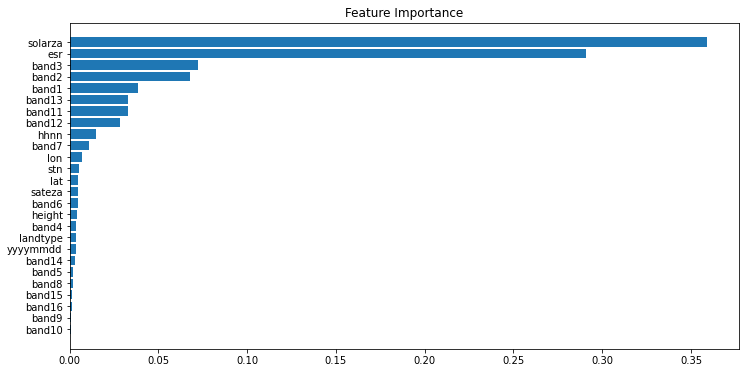

In [30]:
feature_importance = xgb_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_val.columns)[sorted_idx])
plt.title('Feature Importance')

In [48]:
pred = xgb_model.predict(X_test)
submission=pd.read_csv('1-1_검증데이터셋.csv', encoding='utf-8')
submission1=submission.copy()
submission1['UV'] = pred
submission1
submission1.to_csv("220224_xgb_uv.csv", index = False)

In [49]:
submission1

,YearMonthDayHourMinute,STN,UV
0,202206010000,13,6.232414
1,202206010000,105,6.903062
2,202206010000,108,5.712342
3,202206010000,112,6.644337
4,202206010000,115,6.773254
...,...,...,...
51850,202206250000,146,5.387762
51851,202206250000,152,6.760795
51852,202206250000,156,6.326928
51853,202206250000,159,7.475772


In [33]:
submission1['UV'].value_counts()      # 정렬해서 보기

7.106006    35
7.003576    32
6.456372    31
5.738393    29
5.838034    25
            ..
6.655175     1
6.142491     1
6.100989     1
5.463353     1
6.091429     1
Name: UV, Length: 46307, dtype: int64